Track 1: Reducing Boston’s Carbon Footprint: Participants will use the Boston Energy Reporting and Disclosure Ordinance (BERDO), City of Boston Utility Billing Data, City of Boston Real-Time Energy Metering (coming soon!), and other relevant datasets from Analyze Boston to find new ways to promote energy efficiency and reduce greenhouse gas emissions in Boston. You might (for example) analyze the efficiency of individual buildings relative to their characteristics and usage, develop a new map to highlight Boston's greenest buildings, or create graphs of usage over time to see how Boston's demand for energy is evolving over time.

Carbon neutral: making no net release of carbon dioxide to the atmosphere, especially through offsetting emissions by planting trees.

In order to achive a carbon neutral Boston by 2015 the city needs a good tracking system that integrates with the BERDO data. Tracking how buildings are doing thought the years will allow to get insights about what type of buildings are reducing their carbon emissions and which aren't. 

It will also allow to focus on indivual buldings.

This notebook presents a few examples of what information could be track. At this point in time we only have 2 years data which limits the amount of information we can extract. Once we have more year's data the tracking can be considerable improved.

Time was of the essence here as I only had one week till the deadline for submission so there are many things I couldn't acomplish. Whenever this happens I leave a note explaning what can be done in the future when revistint this notebook. This notes start with this tag: **[NOTE/TO DO]**

First, let's import all modules used on this notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import requests

from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
plt.rcParams['axes.facecolor'] = 'white'

import warnings
warnings.filterwarnings('ignore')

Here are the versions of Python, modules, server where this notebook was created:

In [2]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib

2017-04-22 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Next, we load the BERDO datasets available (2014, 2015) and we joined them using the features `Address` and `Property Name`.

In [3]:
# read data
berdo2015 = pd.read_csv(".//data/berdo2015.csv",
                        encoding = "ISO-8859-1")
berdo2014 = pd.read_csv(".//data/berdo2014.csv",
                        encoding = "ISO-8859-1")

# sizes
print("Size of BERDO 2014 data set: %s" %(berdo2014.shape[0]))
print("Size of BERDO 2015 data set: %s" %(berdo2015.shape[0]))
print("\n........ Merging ........\n")

# merge
berdo = pd.merge(berdo2015,
                 berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014')) # sufixes for both data sets

# final size
print("Size of joined BERDO data set: %s" %(berdo.shape[0]))

Size of BERDO 2014 data set: 1380
Size of BERDO 2015 data set: 1502

........ Merging ........

Size of joined BERDO data set: 1085


**[NOTE/TO DO]** Not all buildings were in both data sets, at least the property name/address didn't match for all listings. A simple typo would have left some listing out of the final data set. We would need to inspect the data set to see if this is the case.

Of all the data set we are interested in the following features:

* **Property Name**: Property name, as reported by owner
* **Address**: Reported address
* **ZIP**: ZIP Code
* **Site EUI (kBTU/sf)**: Site energy use intensity, or EUI (in kBTU/sq. ft.): This sums up all of the energy used in the building (electricity, gas, steam, etc.) each year, and divides by square footage. There are many drivers of energy use intensity, such as energy-intensive work, and, since EUI is not adjusted for these factors, it is not a definitive indicator of building efficiency. (This metric uses site energy, not source energy.)
* **Property Uses**: List of space uses reported for this property
* **Year Built**: Year built, as reported by the owner
* **GHG Intensity (kgCO2/sf)**: GHG intensity (kgCO2/sf) divides total GHG emissions by square footage.
* **Total Site Energy (kBTU)**: Total energy used in 2014 (kBTU). This is a gross sum of all annual energy use in the building, not adjusted for size or uses.
* **% Electricity**: Percent of total energy that is electricity
* **% Gas**: Percent of total energy that is gas
* **% Steam**: Percent of total energy that is steam

Next, we proceed to clean the data set, here are the steps taken:

* `fix_numerical`: columns that are considered numerical are transformed into an number
* `fix_percenteage`: columns with a percent are transforemd into numbers
* bad values are transfored into `-1`

In [4]:
cols_num = ['Gross Area (sq ft)',
            'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)',
            'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ',
            'Water Intensity (gal/sf)'
           ]

cols_percent = ["% Gas",
                "% Steam",
                "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%",
                                inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columns
fix_numerical(cols_num)
fix_percenteage(cols_percent)

We calculate the total % of energy adding the 3 % features. We want to check how many of them add up to 100%. We could filter out the ones that are not close to 100 but there might me other sources of energy not reported so we decide to leave those observations in.

Some buildings were built before America Columbus got to America. This is clearly a typo. It makes sense that the typo comes from the first character of year being a 1 intead of a 2. We make that tranformation. Other errors are changed to our null value `-1`. This feature is later used to create the feature `decade`. This will allow us to group properties by the decade they were built.

In [5]:
# calculates total enery to see if it adds up to 100%
berdo["%_total_2015"] = berdo[["% Gas_2015",
                               "% Steam_2015",
                               "% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014",
                               "% Steam_2014",
                               "% Electricity_2014"]].sum(axis=1)

# fix 'year built' 
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x:
                                                        x+1000 
                                                        if ((x < 1013) and (x > 800)) 
                                                        else x)
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x:
                                                        -1 
                                                        if x <=800
                                                        else x)

# create feature `decade`
berdo["decade"] = berdo["Year Built_2015"].map(lambda x: 
                                               int(str(x)[:-1]+"0"))

Removing missing values or bad data:

In [6]:
print("Size before removing bad/missing values: %s" %berdo.shape[0])

# feature selection
berdo = berdo[["Property Name","Address","ZIP_2015",
               "Year Built_2015","decade",
               "Property Type_2015","Property Type_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               "GHG Emissions (MTCO2e)_2015","GHG Emissions (MTCO2e)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014"
              ]]

# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)

print("Size after removing bad/missing values: %s" %berdo.shape[0])

Size before removing bad/missing values: 1085
Size after removing bad/missing values: 986


99 observations were removed due to either missing values or bad data.

**[NOTE/TO DO]** We could inpect this further to try to fix those observations.

Now, we are creating a final `Data.Frame` called `berdo_diff` that will have the difference between the year 2015 and 2014.

2015 data will be subtracted from 2014 data, thus, positive values mean a decrease (2014 data was higher than 2015 data) and negative values mean there has been and increase.

In [7]:
# new data frame
berdo_diff = pd.DataFrame()

# property info
berdo_diff[["property_name", "address",
            "zip","year_built","decade"]] = berdo[["Property Name",
                                                   "Address","ZIP_2015",
                                                   "Year Built_2015","decade"]]
# property type
berdo_diff[["property_type_2015",
            "property_type_2014"]] = berdo[["Property Type_2015",
                                            "Property Type_2014"]]

# energy diff
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2014"] \
                                  - berdo["Site EUI (kBTU/sf)_2015"]

# ghg diff
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2014"] \
                                          - berdo["GHG Intensity (kgCO2/sf)_2015"]

# energy %
berdo_diff[["%_electricity_2015",
            "%_gas_2015",
            "%_steam_2015"]] = berdo[["% Electricity_2015",
                                      "% Gas_2015",
                                      "% Steam_2015"]]
berdo_diff[["%_electricity_2014",
            "%_gas_2014",
            "%_steam_2014"]] = berdo[["% Electricity_2014",
                                      "% Gas_2014",
                                      "% Steam_2014"]]

To plot the properties on a map we need the latitude and longitude. There are many ways to do this. I use google maps API to look for the address and extract both longitued and latitude. the process is run a second time (`redo_long_lat`) in case some API called timed out the first iteration.

In [ ]:
import requests

def get_long_lat(address):
    """recieves and Boston address and looks for longitude 
       and latitude using google maps API. Returns string 
       with both values. Values are 0 if error """
    
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
            + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)


def redo_long_lat(row):
    """if the field lat_long is '0 0'
       the funtion tries to retrieve longitude 
       and latitude from google maps API"""
    
    if row["lat_long"] == "0 0":
        address = row["address"]  
        fix_add = address.replace(" ","+")
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
                + fix_add + ',+Boston,+Massachusetts,+USA'
        try:        
            response = requests.get(url)
            resp_json_payload = response.json()
            #print(resp_json_payload)
            info = (resp_json_payload['results'][0]['geometry']['location'])
            return str(info['lat'])+" "+str(info['lng'])
        except:
            return "0 0" 
    else:
        return row["lat_long"]

berdo_diff["lat_long"] =  berdo_diff.apply(redo_long_lat, axis=1)

# creates features longitude and latitude
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

In [ ]:
# checks and save
print(berdo_diff.lat_long.isnull().sum())
print(berdo_diff.lat_long.value_counts()[:5])
#berdo_diff.drop(["lat_long"],inplace=True)
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

In [ ]:
berdo_diff = pd.read_csv("./data/berdo_diff.csv")

## 2. TRACKING VISUALIZATIONS

This second part of the notebook shows some visualizations to help tracking energy and green house emissions.

First, we want to see all properties in a map coloring them:

* Increase: value in 2015 was higher that in 2014 (red)
* Neutral: value in 2015 was the same as in 2014 (yellow)
* Decrease: value in 2015 was lower that in 2014 (green)

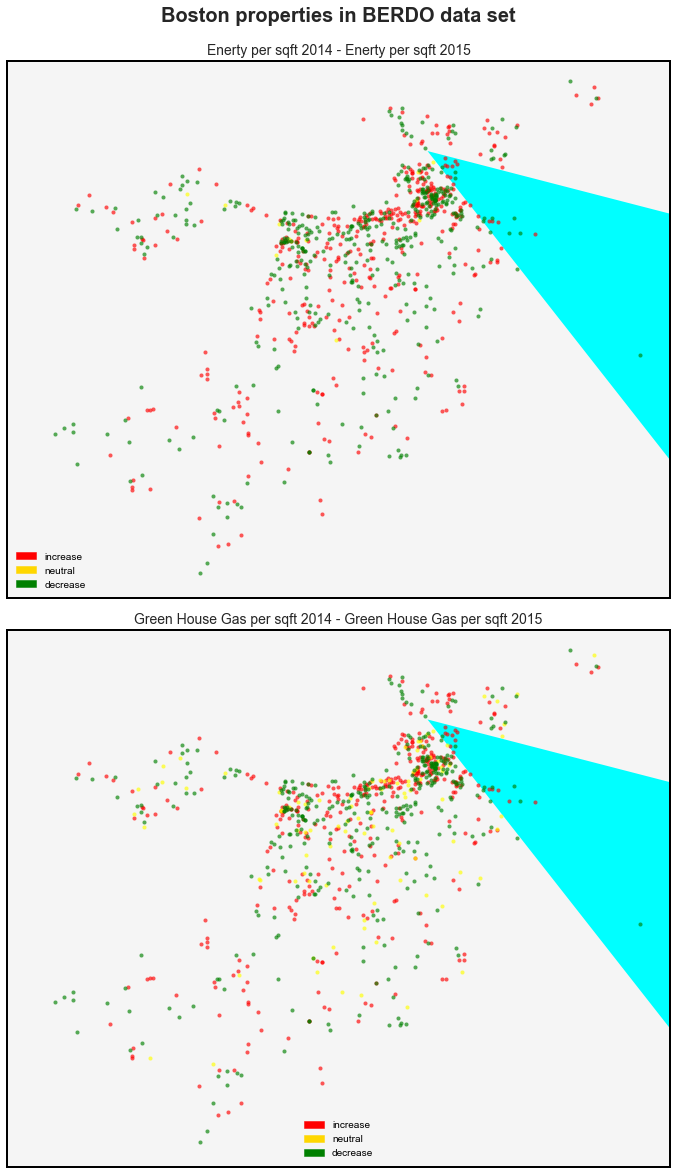

In [48]:
# boston limits
west, south, east, north = -71.1958, 42.2254, -70.9804, 42.40

# figure
fig = plt.figure(figsize=(12,16),
                 facecolor='white')

plt.suptitle("Boston properties in BERDO data set", y=1.02, fontsize=20,fontweight = 'bold')


########################### ENERGY MAP
fig.add_subplot(211)
plt.title("Enerty per sqft 2014 - Enerty per sqft 2015", size=14)

# coloring split
increase = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north, 
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='l')

m.fillcontinents(color='whitesmoke',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="aqua")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.65,
       markeredgecolor='yellow',
       markeredgewidth=0.05) 


m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='gold',
                              label='neutral')
green_patch = mpatches.Patch(color='green',
                             label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch,
                        ])

for text in l.get_texts():
    text.set_color("black")
    
    
########################### GHG MAP
fig.add_subplot(212)
plt.title("Green House Gas per sqft 2014 - Green House Gas per sqft 2015", size=14)

# coloring split
increase = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='l')

m.fillcontinents(color='whitesmoke',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="white")


# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.65,
       markeredgecolor='yellow',
       markeredgewidth=0.06) 


m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='gold',
                              label='neutral')
blue_patch = mpatches.Patch(color='blue',
                            label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch
                       ])

for text in l.get_texts():
    text.set_color("black")

# show figure    
plt.tight_layout()    
plt.show()

Explain map!!!

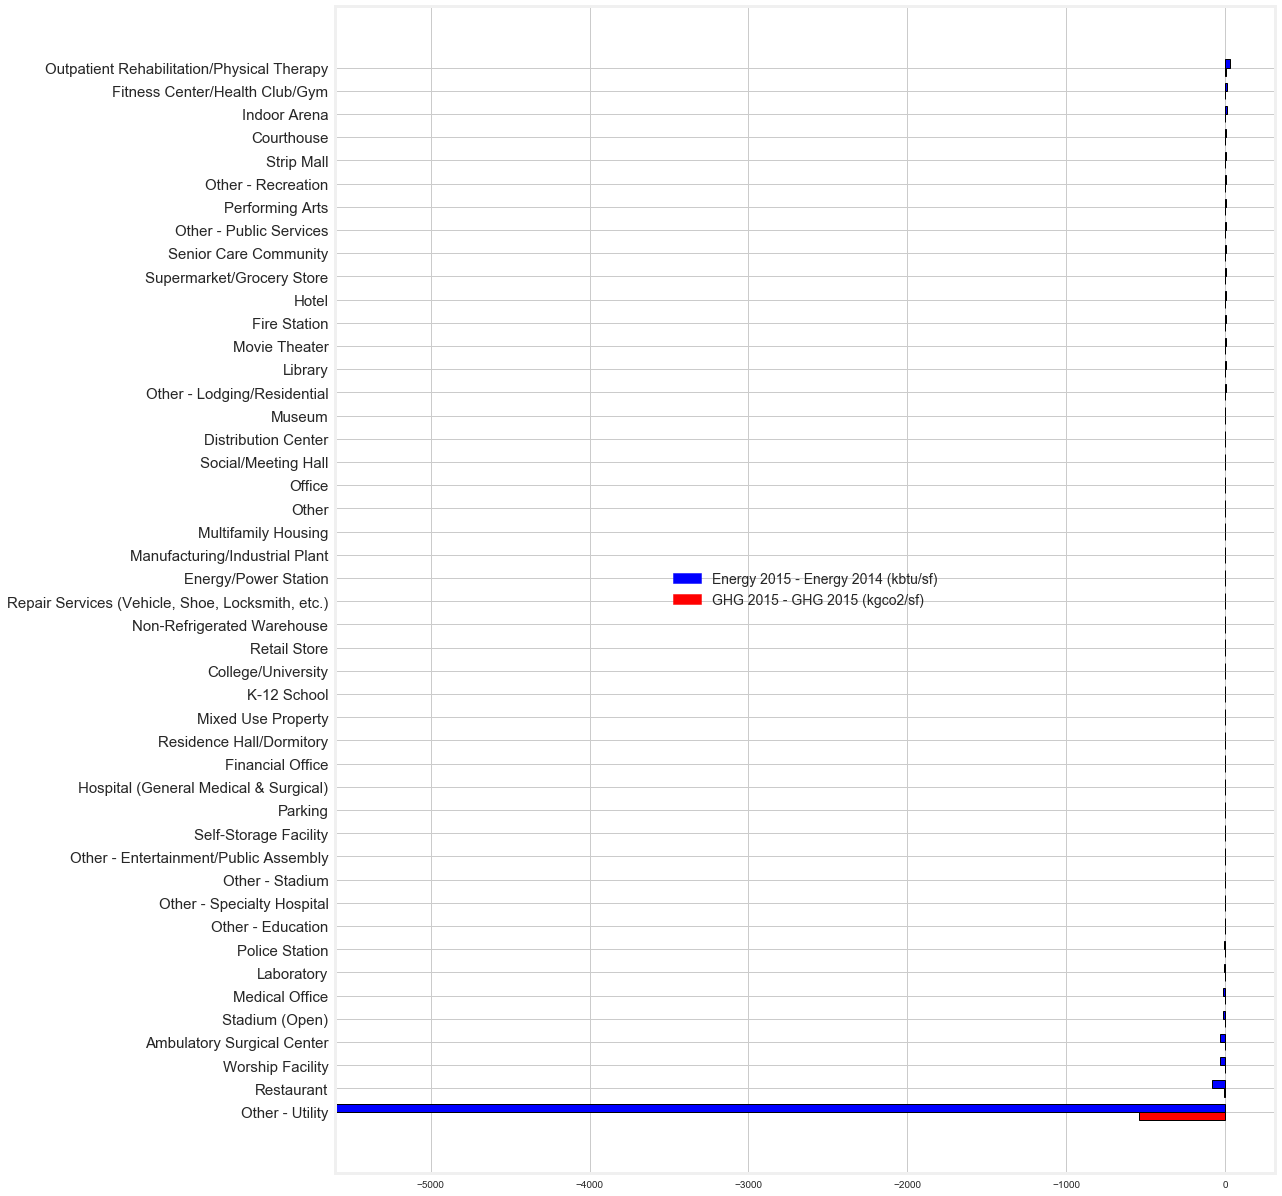

In [8]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

# plot 
plt.figure(figsize=(15, 20),
           facecolor='white')

ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb,
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='center',
               prop={'size':14})

plt.show()

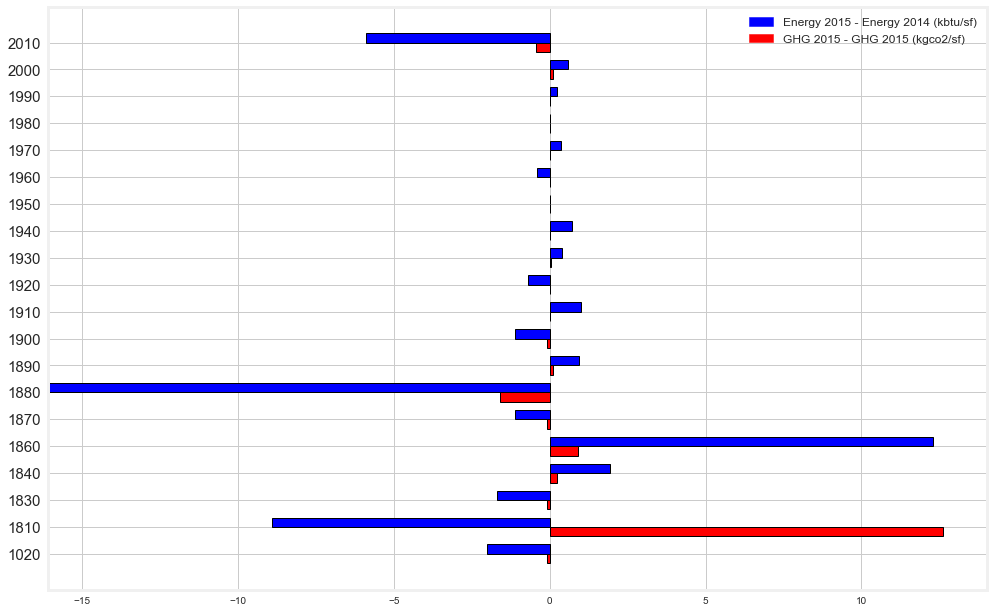

In [9]:
# data to plot
a = berdo_diff.groupby(["decade"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["decade"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_index()

# plot
plt.figure(figsize=(15, 10),
           facecolor='white')
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='upper right',
               prop={'size':12})

plt.show()

In [ ]:
berdo_diff['ghg_intensity_kgco2/sf_diff'].value_counts().sort_index().iloc[:10]

In [ ]:
berdo_diff['ghg_intensity_kgco2/sf_diff'].value_counts().sort_index().iloc[-10:]

In [ ]:
bad_energy_share

In [ ]:
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

In [ ]:
 berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

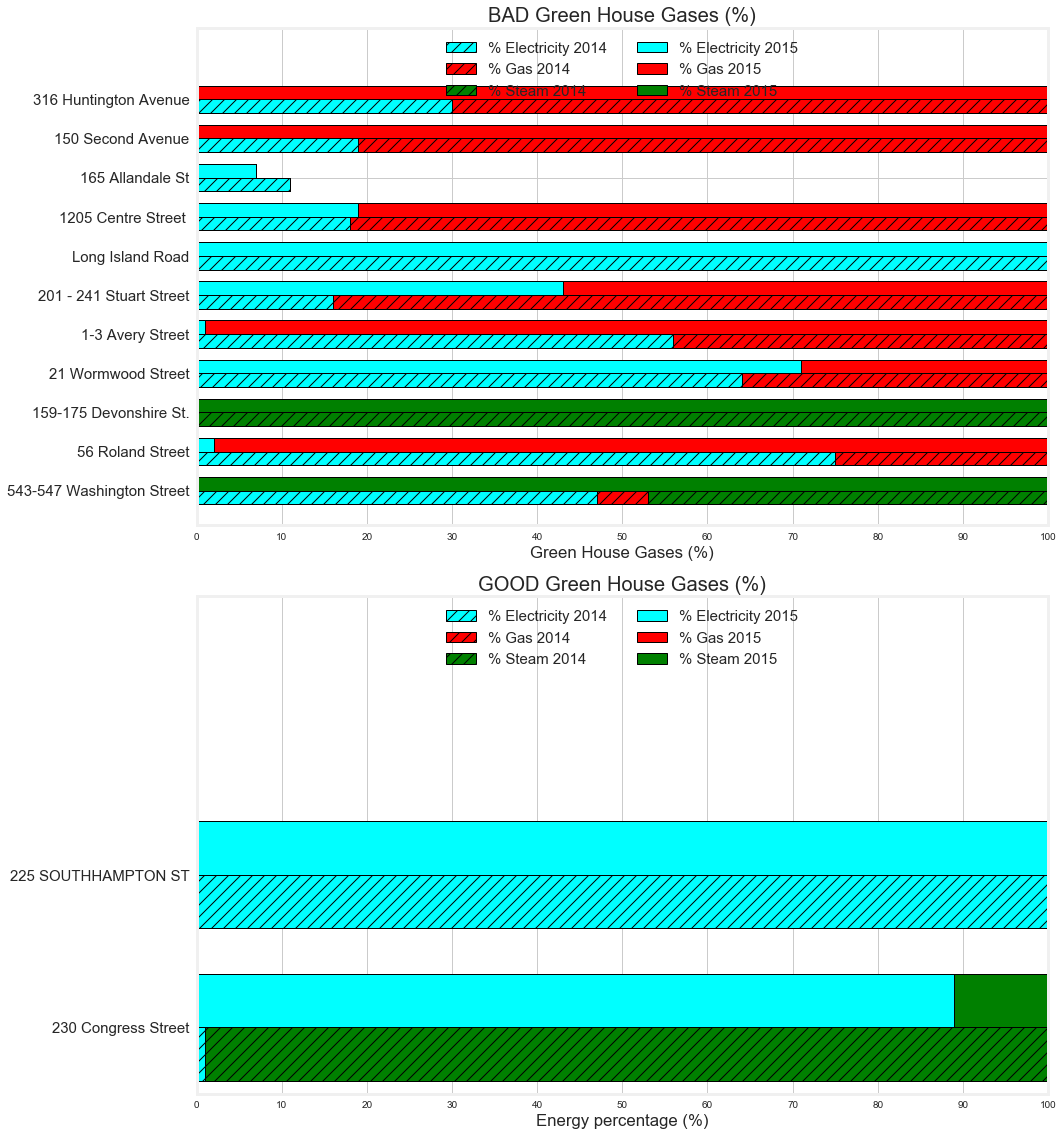

In [10]:
############################ BEST


# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['ghg_intensity_kgco2/sf_diff'] > 15]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(15,16),
                 facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Green House Gases (%)')
plt.title('BAD Green House Gases (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)

############################ BEST

# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['ghg_intensity_kgco2/sf_diff'] < -100]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax=plt.subplot2grid((2,1), (1,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('GOOD Green House Gases (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()

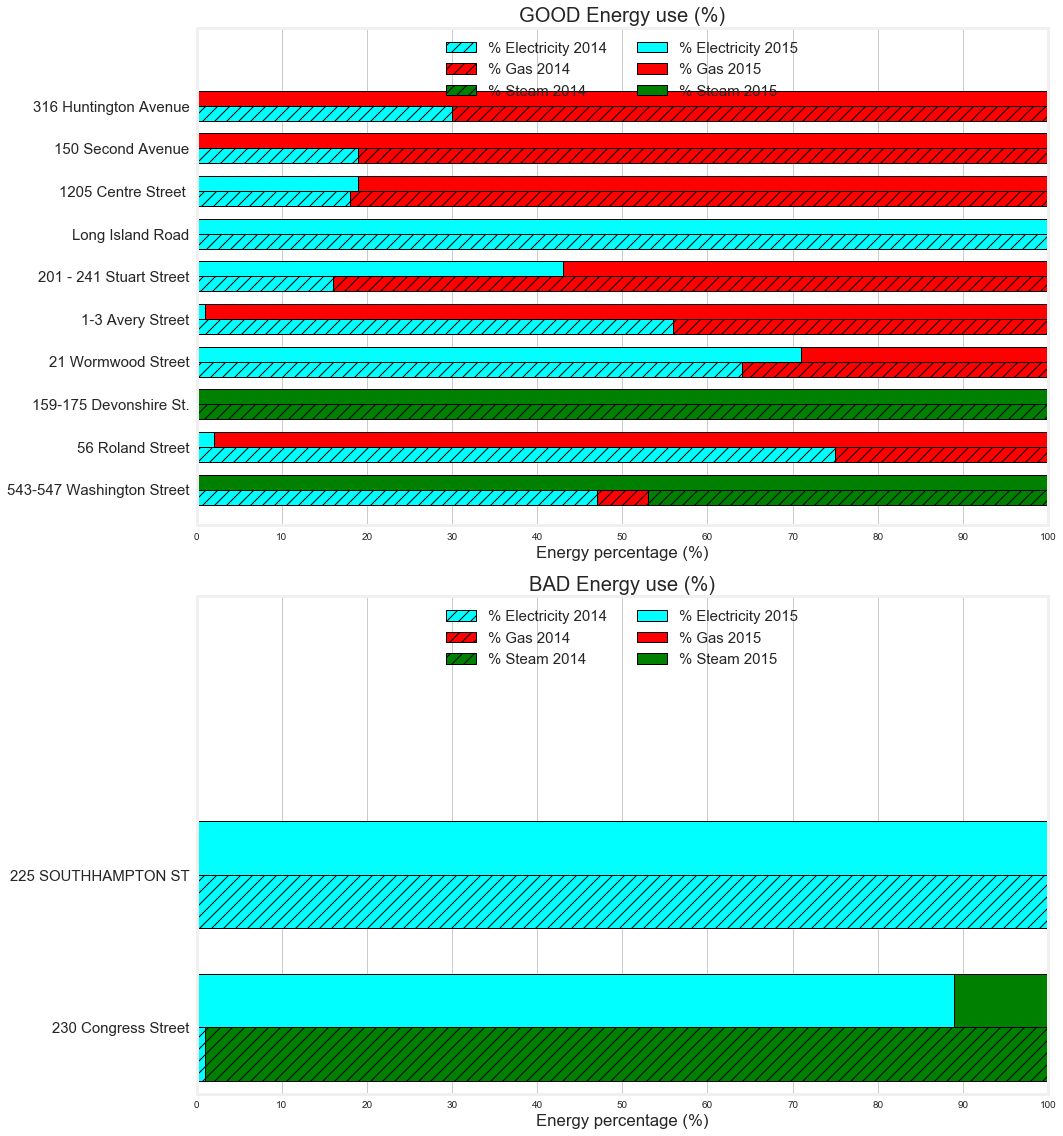

In [11]:
############################ BEST


# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(15,16),
                 facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('GOOD Energy use (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)

############################ BEST

# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] < -1000]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax=plt.subplot2grid((2,1), (1,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('BAD Energy use (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()

In [ ]:
ax.set_ylabel('Words')
ax.set_title('Word Frequencies by Test and Training Set')
ax.set_xticks(ind,minor=False)
ax.set_xticks(ind + width,minor=True)
ax.set_xticklabels(words_1,rotation=90,minor=False,ha='left')
ax.set_xticklabels(words_2,rotation=90,minor=True,ha='left')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.tick_params(axis='both', which='minor', labelsize=6)

In [ ]:
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

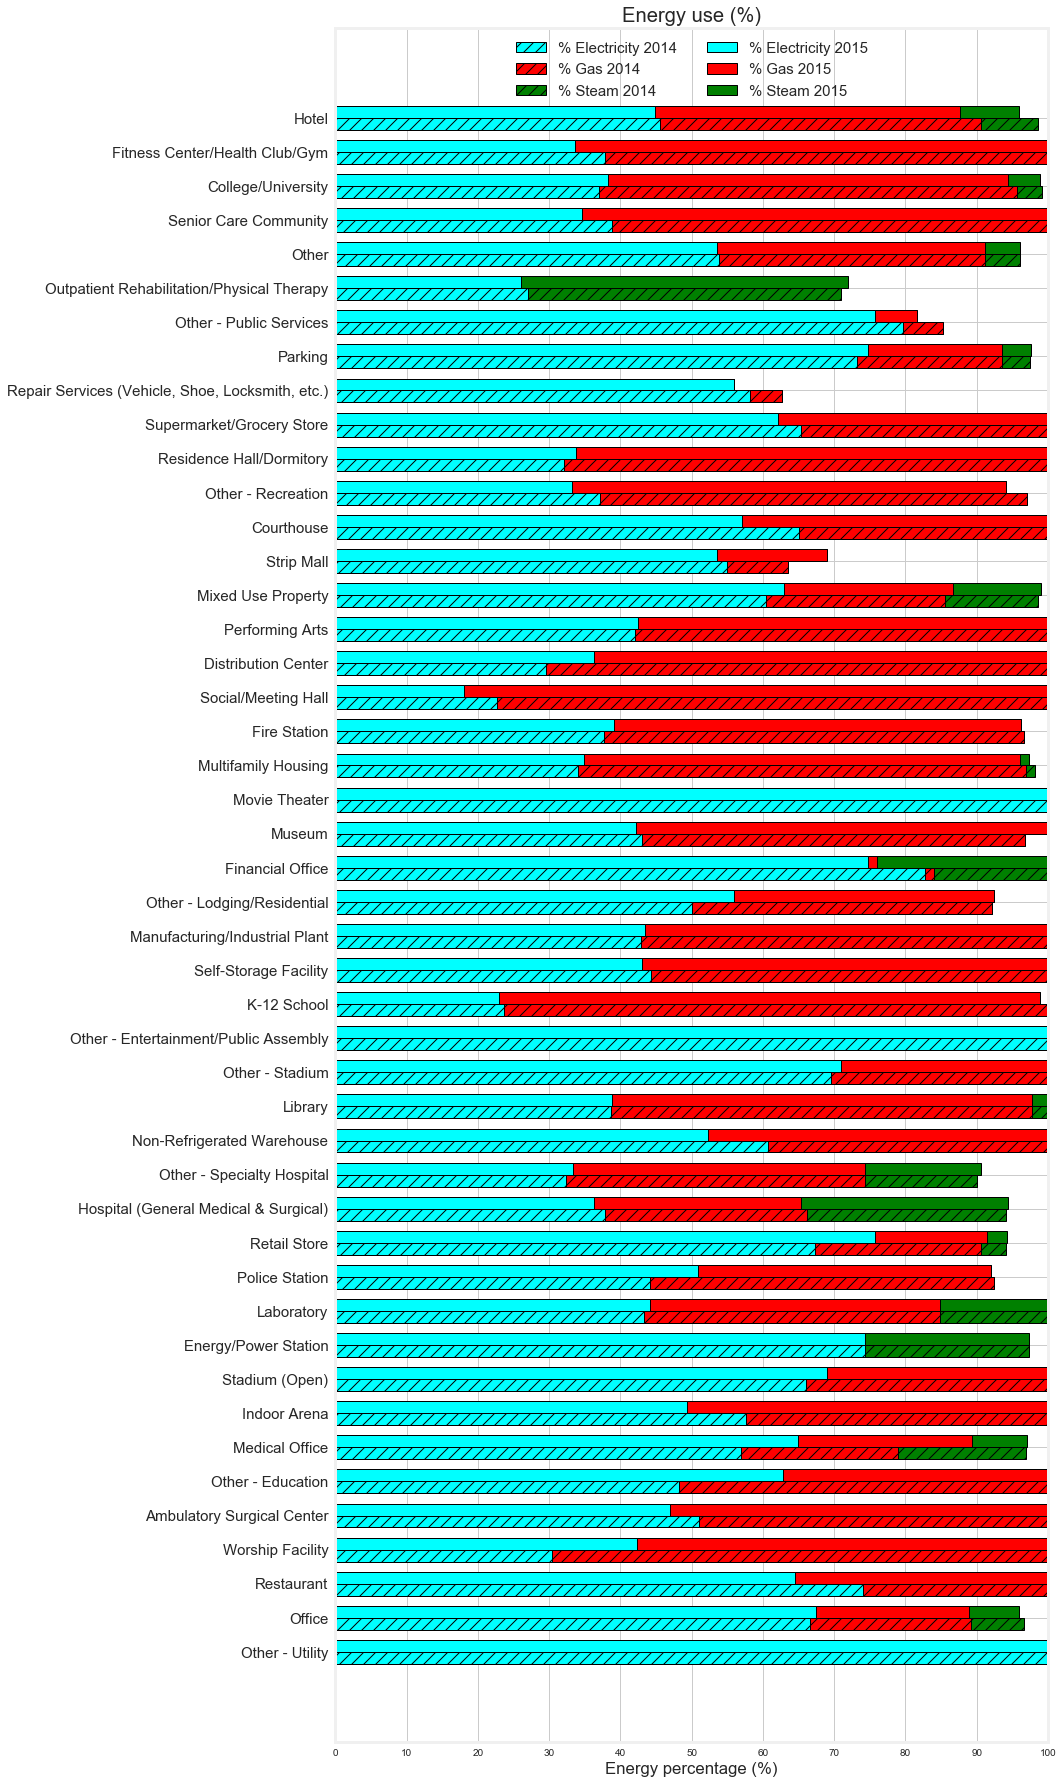

In [12]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                               "%_gas_2014","%_steam_2014","%_electricity_2015",
                                               "%_gas_2015","%_steam_2015"]].mean()


a = a[a <1000].sort_values(by='energy_kbtu/sf_diff')


b = berdo_diff.groupby(["property_type_2015"])[['ghg_intensity_kgco2/sf_diff']].mean()
b = b[b <500].sort_values(by='ghg_intensity_kgco2/sf_diff')

c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

bad_energy_share = c

#stacked bars
width = 0.35 
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups

fig = plt.figure(figsize=(15,25),
                 facecolor='white')

ax=plt.subplot2grid((1,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('Energy use (%)')
#plt.yticks(ind, bad_energy_share.index.values)
plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()